In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label={0: 'No', 1: 'Yes'}, label2id={'No': 0, 'Yes': 1})

/home/op/miniconda3/envs/lat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
data_path = '/ssd4tb/huggingface_cache/datasets/adversarial-data/adversarial-data/train'

in_dist = pd.read_csv(os.path.join(data_path, 'initial_in_domain.csv'))
adv = pd.read_csv(os.path.join(data_path, 'manual_adversarial_examples.csv'))

# remove best_label column == 'Unsure'

in_dist = in_dist[in_dist['best_label'] != 'Unsure']
adv = adv[adv['best_label'] != 'Unsure']

print(in_dist['best_label'].value_counts())
print(adv['best_label'].value_counts())

in_dist['text'] = in_dist['prompt'] + ' ' + in_dist['completion'] 
adv['text'] = adv['prompt'] + ' ' + adv['completion']

del in_dist['prompt']
del in_dist['completion']
del adv['prompt']
del adv['completion']

in_dist['label'] = in_dist['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)
adv['label'] = adv['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)

del in_dist['best_label']
del adv['best_label']

No     149296
Yes     17134
Name: best_label, dtype: int64
No     847
Yes    771
Name: best_label, dtype: int64


In [3]:
in_dist = in_dist.dropna()
adv = adv.dropna()

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# balance dataset
min_class = min(in_dist['label'].value_counts())
min_adv_class = min(adv['label'].value_counts())
in_dist = pd.concat([in_dist[in_dist['label'] == 0].sample(min_class), in_dist[in_dist['label'] == 1].sample(min_class)])
adv = pd.concat([adv[adv['label'] == 0].sample(min_adv_class), adv[adv['label'] == 1].sample(min_adv_class)])

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# shuffle 
in_dist = in_dist.sample(frac=1)
adv = adv.sample(frac=1)


0    149296
1     17134
Name: label, dtype: int64
0    844
1    770
Name: label, dtype: int64
0    17134
1    17134
Name: label, dtype: int64
0    770
1    770
Name: label, dtype: int64


In [4]:
# ### temp loss calculation 

# in_dist = in_dist.dropna()
# adv = adv.dropna()

# in_dist = in_dist.to_dict('records')
# adv = adv.to_dict('records')

# # tokenize
# in_dist = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(in_dist)]
# adv = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(adv)]

In [5]:
# # create tensor dataset
# in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]))
# adv_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in adv]), torch.tensor([elem['label'] for elem in adv]))

# # create dataloader
# in_dist_dataloader = torch.utils.data.DataLoader(in_dist_dataset, batch_size=128)
# adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=128)

# # measure loss on each datapoint and add to datasets
# in_dist_loss = []
# adv_loss = []

# device = 0
# model.to(device)
# model.eval()
# criterion = torch.nn.CrossEntropyLoss(reduction='none')

# tokenizer.pad_token = tokenizer.eos_token

# for batch in tqdm(in_dist_dataloader):
#     with torch.no_grad():
#         input_ids = batch[0].to(device)
#         labels = batch[1].to(device)

#         outputs = model(input_ids=input_ids, labels=labels)
#         loss = criterion(outputs.logits, labels)

#         in_dist_loss += loss.tolist()
#         del loss
        
# for batch in tqdm(adv_dataloader):
#     with torch.no_grad():
#         input_ids = batch[0].to(device)
#         labels = batch[1].to(device)

#         outputs = model(input_ids=input_ids, labels=labels)
#         loss = criterion(outputs.logits, labels)
        
#         adv_loss += loss.tolist()
#         del loss

# in_dist_loss = np.array(in_dist_loss)
# adv_loss = np.array(adv_loss)

In [6]:
# np.save('gpt2_in_dist_loss.npy', in_dist_loss)
# np.save('gpt2_adv_loss.npy', adv_loss)

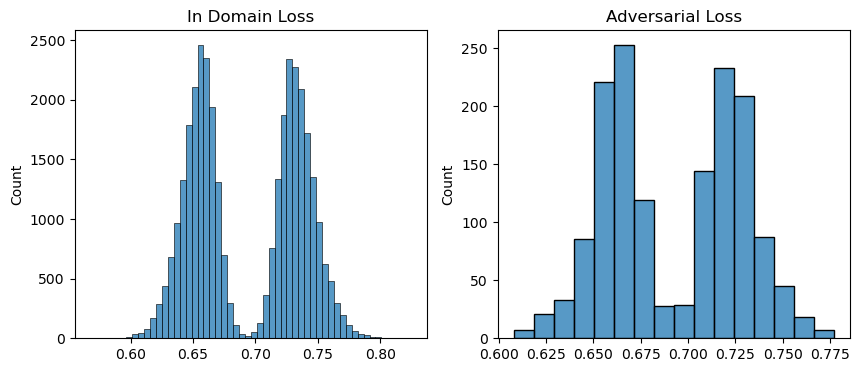

In [7]:
in_dist_loss = np.load('bert_in_dist_loss.npy')
adv_loss = np.load('bert_adv_loss.npy')


fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(in_dist_loss, ax=axs[0])
sns.histplot(adv_loss, ax=axs[1])
axs[0].set_title('In Domain Loss')
axs[1].set_title('Adversarial Loss')
plt.show()

In [8]:
in_dist = in_dist.to_dict('records')
adv = adv.to_dict('records')

# each elem looks like {'text': "wakens  \n  \n  \nThe harsh light of the midday sun cascaded over the young Mr. Quest's sleeping form. As the light slowly penetrated the skin of his eyelids a bit he stirred, obviously being roused (albeit slowly) from his peaceful slumber. But for once, even this short period of light did not bother him.",
#   'label': 0},

# tokenize
in_dist = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(in_dist, in_dist_loss))]
adv = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(adv, adv_loss))]

34268it [00:05, 5878.98it/s]
1540it [00:00, 6940.18it/s]


In [31]:
# create tensor dataset
in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]), torch.tensor([elem['loss'] for elem in in_dist]))
adv_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in adv]), torch.tensor([elem['label'] for elem in adv]), torch.tensor([elem['loss'] for elem in adv]))

In [32]:
in_dist_true = in_dist_dataset.tensors[1] == 1
in_dist_true = in_dist_dataset[in_dist_true]
in_dist_false = in_dist_dataset.tensors[1] == 0
in_dist_false = in_dist_dataset[in_dist_false]

in_dist_true = torch.utils.data.TensorDataset(in_dist_true[0], in_dist_true[1], in_dist_true[2])
in_dist_false = torch.utils.data.TensorDataset(in_dist_false[0], in_dist_false[1], in_dist_false[2])

in_dist_train_size = int(len(in_dist_true)*0.98)

in_dist_train_true, in_dist_val_true = torch.utils.data.random_split(in_dist_true, [in_dist_train_size, len(in_dist_true) - in_dist_train_size])
in_dist_train_false, in_dist_val_false = torch.utils.data.random_split(in_dist_false, [in_dist_train_size, len(in_dist_false) - in_dist_train_size])

in_dist_train = torch.utils.data.ConcatDataset([in_dist_train_true, in_dist_train_false])
in_dist_val = torch.utils.data.ConcatDataset([in_dist_val_true, in_dist_val_false])

adv_true = adv_dataset.tensors[1] == 1
adv_true = adv_dataset[adv_true]
adv_false = adv_dataset.tensors[1] == 0
adv_false = adv_dataset[adv_false]

adv_true = torch.utils.data.TensorDataset(adv_true[0], adv_true[1], adv_true[2])
adv_false = torch.utils.data.TensorDataset(adv_false[0], adv_false[1], adv_false[2])

val_train_size = int(len(adv_true)*0.8)

adv_train_true, adv_val_true = torch.utils.data.random_split(adv_true, [val_train_size, len(adv_true) - val_train_size])
adv_train_false, adv_val_false = torch.utils.data.random_split(adv_false, [val_train_size, len(adv_false) - val_train_size])

adv_val = torch.utils.data.ConcatDataset([adv_val_true, adv_val_false])
adv_train = torch.utils.data.ConcatDataset([adv_train_true, adv_train_false])

In [11]:
# training loop
# train on in_dist_train_dataset
# eval on in_dist_val_dataset_true, in_dist_val_dataset_false, adv_val_dataset_true, adv_val_dataset_false

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

def train(model, optimizer, criterion, train_dataset, train_batch_size, eval_datasets, eval_batch_size, device, num_epochs=1): 
    model.train()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    batchwise_loss = []
    eval_losses = []

    for epoch in range(num_epochs):
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            # outputs = model(input_ids=input_ids, labels=input_ids)
            # logits = outputs.logits
            # loss = outputs.loss

            # logits = logits[:, :-1, :].contiguous()
            # input_ids = input_ids[:, 1:].contiguous()
            # input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)

            # loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).mean(-1)
            # # labels = batch[1].to(device)
            # # loss = torch.where(labels == 1, loss, 0.1 * -loss)
            # loss = loss.mean()

            # # assert torch.allclose(loss, outputs.loss.mean(), rtol=1e-1), f'{loss} != {outputs.loss.mean()}'
            
            loss = loss.mean()

            loss.backward()
            optimizer.step()

            accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()

            # num_na = 0
            # for p in model.parameters(): 
            #     num_na += torch.sum(torch.isnan(p)).item()
            # print(num_na)

            batchwise_loss.append(accuracy)
            eval_stats = []
            for eval_dataset in eval_datasets:
                eval_acc, eval_tpr, eval_fpr, eval_tnr, eval_fnr = eval_model(model, criterion, eval_dataset, eval_batch_size, device)
                eval_stats.append((eval_acc, eval_tpr, eval_fpr, eval_tnr, eval_fnr))
            eval_losses.append(eval_stats)
            
            # if i % 5 == 0: 
            #     in_dist_true_loss = [elem[0] for elem in eval_losses]
            #     in_dist_false_loss = [elem[1] for elem in eval_losses]
            #     adv_true_loss = [elem[2] for elem in eval_losses]
            #     adv_false_loss = [elem[3] for elem in eval_losses]

            #     sns.set()
            #     sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
            #     sns.lineplot(x=range(len(in_dist_true_loss)), y=in_dist_true_loss, label='in_dist_true')
            #     sns.lineplot(x=range(len(in_dist_false_loss)), y=in_dist_false_loss, label='in_dist_false')
            #     sns.lineplot(x=range(len(adv_true_loss)), y=adv_true_loss, label='adv_true')
            #     sns.lineplot(x=range(len(adv_false_loss)), y=adv_false_loss, label='adv_false')
            #     plt.legend()
            #     plt.show()

            if i % 5 == 0: 
                in_dist_val_acc, in_dist_val_tpr, in_dist_val_fpr, in_dist_val_tnr, in_dist_val_fnr = eval_model(model, criterion, eval_datasets[0], eval_batch_size, device)
                adv_val_acc, adv_val_tpr, adv_val_fpr, adv_val_tnr, adv_val_fnr = eval_model(model, criterion, eval_datasets[1], eval_batch_size, device)
                
                sns.set()
                sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[0][0] for elem in eval_losses], label='in_dist_val_acc')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[1][0] for elem in eval_losses], label='adv_val_acc')

                plt.legend()

                plt.show()

        torch.cuda.empty_cache()

    return batchwise_loss, eval_losses
    
def eval_model(model, criterion, eval_dataset, eval_batch_size, device):
    model.eval()
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=True)
    accuracies = []
    tpr, fpr, tnr, fnr = [], [], [], []
    with torch.no_grad(): 
        for batch in eval_loader: 
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()
            accuracies.append(accuracy)
            tpr.append(((torch.argmax(outputs.logits, dim=1) == labels) & (labels == 1)).float().mean().item())
            fpr.append(((torch.argmax(outputs.logits, dim=1) != labels) & (labels == 0)).float().mean().item())
            tnr.append(((torch.argmax(outputs.logits, dim=1) == labels) & (labels == 0)).float().mean().item())
            fnr.append(((torch.argmax(outputs.logits, dim=1) != labels) & (labels == 1)).float().mean().item())
    return np.mean(accuracies), np.mean(tpr), np.mean(fpr), np.mean(tnr), np.mean(fnr)

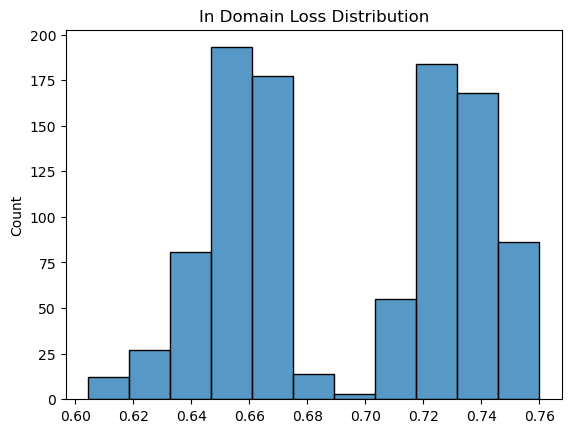

In [12]:
bootstrap_high_size = 1000
high_frac = 0
final_train_size = 1000

high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# sample high_frac of high loss examples
high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
to_train = torch.utils.data.ConcatDataset([high, rem])
to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # randomly sample target_train_size examples from in_dist_train
# to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

sns.histplot([elem[2].item() for elem in to_train])
plt.title('In Domain Loss Distribution')
plt.show()

In [13]:
len(to_train), len(in_dist_val), len(adv_train), len(adv_val)

(1000, 686, 1232, 308)

  0%|          | 0/16 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


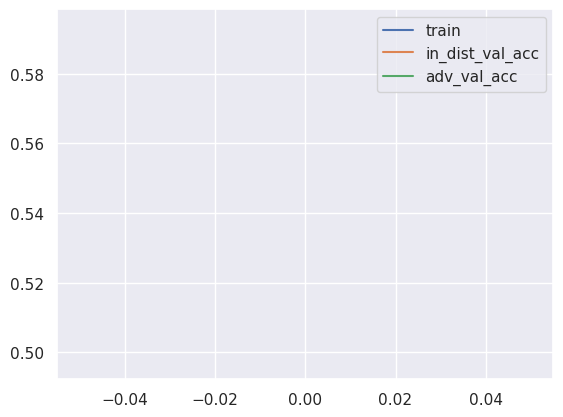

 31%|███▏      | 5/16 [00:23<00:46,  4.23s/it]

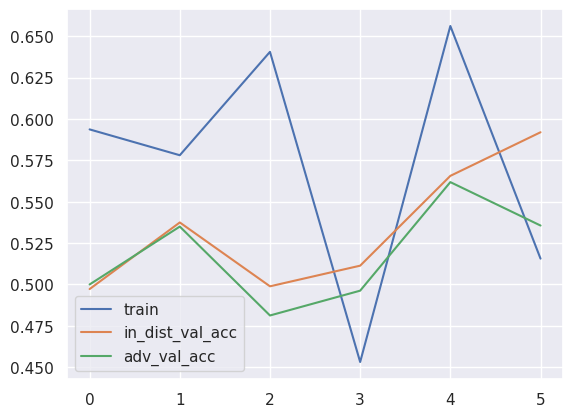

 62%|██████▎   | 10/16 [00:47<00:26,  4.40s/it]

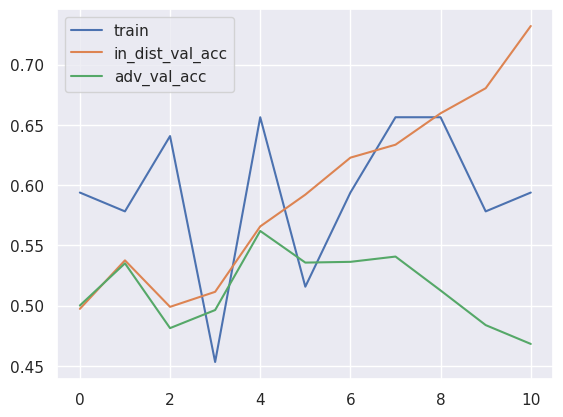

 94%|█████████▍| 15/16 [01:12<00:04,  4.52s/it]

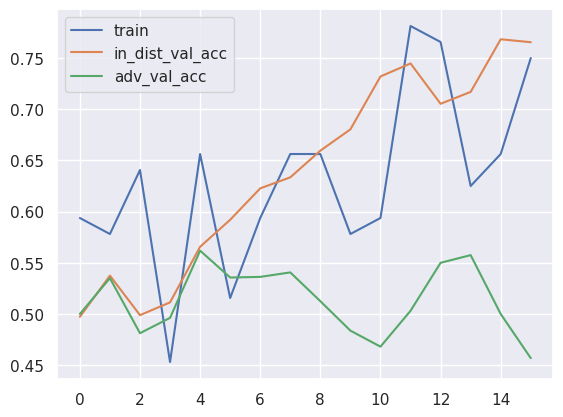

  0%|          | 0/16 [00:00<?, ?it/s]

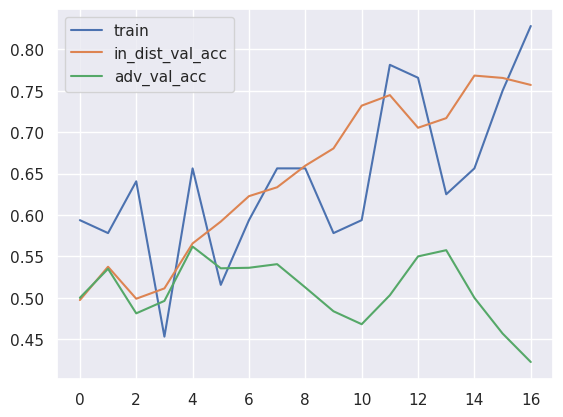

 31%|███▏      | 5/16 [00:25<00:50,  4.61s/it]

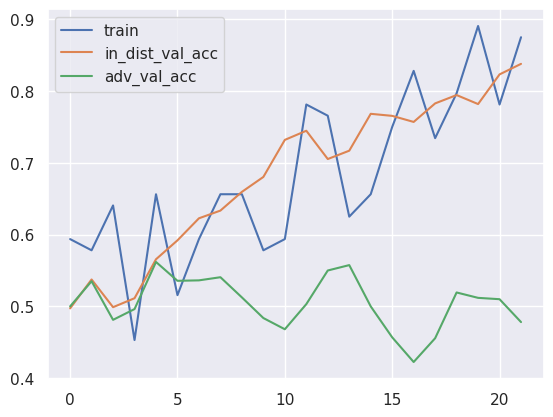

 62%|██████▎   | 10/16 [00:50<00:27,  4.64s/it]

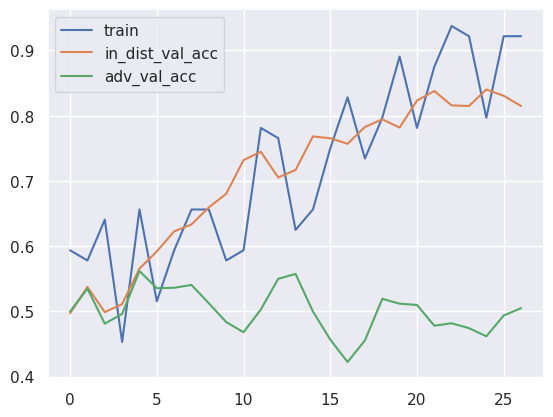

 94%|█████████▍| 15/16 [01:16<00:04,  4.66s/it]

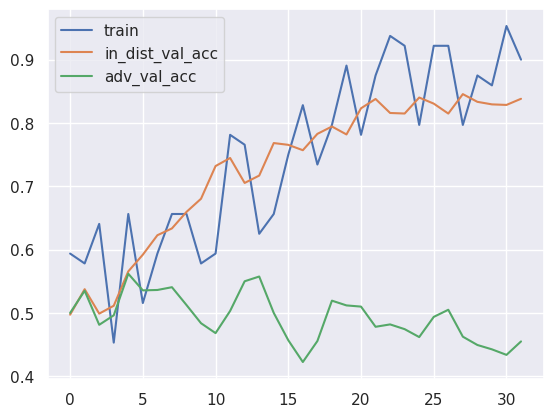

100%|██████████| 16/16 [01:24<00:00,  5.30s/it]


In [14]:
train_batch_size = 64
eval_batch_size = 64
device = 0
model.to(device)

train_loss, eval_losses = train(model, optimizer, criterion, to_train, train_batch_size, [in_dist_val, adv_dataset], eval_batch_size, device, num_epochs=2)

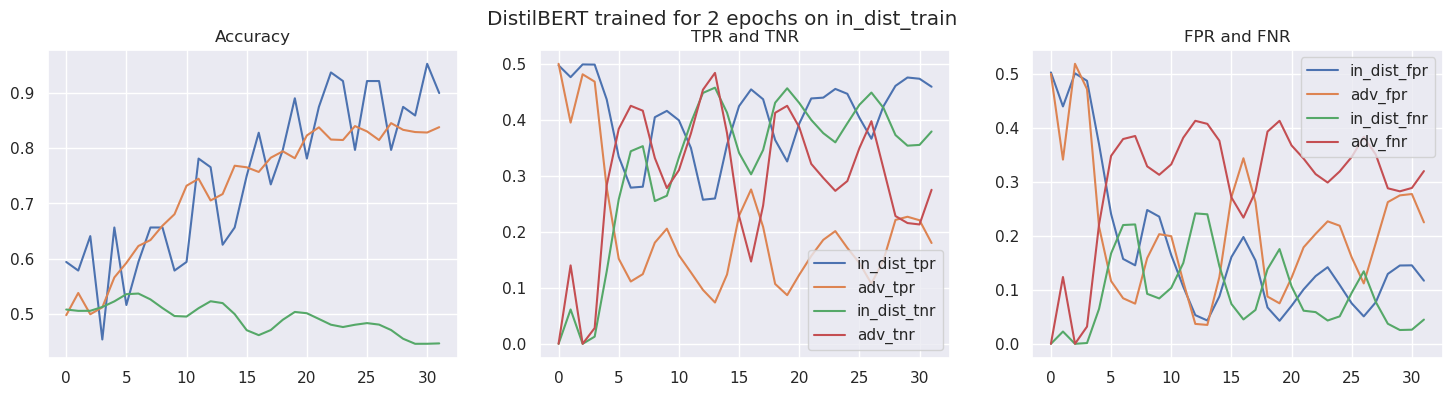

In [16]:
eval_losses = np.array(eval_losses)

in_dist_acc, in_dist_tpr, in_dist_fpr, in_dist_tnr, in_dist_fnr = eval_losses[:, 0, 0], eval_losses[:, 0, 1], eval_losses[:, 0, 2], eval_losses[:, 0, 3], eval_losses[:, 0, 4]
adv_acc, adv_tpr, adv_fpr, adv_tnr, adv_fnr = eval_losses[:, 1, 0], eval_losses[:, 1, 1], eval_losses[:, 1, 2], eval_losses[:, 1, 3], eval_losses[:, 1, 4]

# create 3 x 1 plots

import statsmodels.api as sm

fig, axs = plt.subplots(1,3, figsize=(18, 4))
sns.set()

lowess = sm.nonparametric.lowess(train_loss, range(len(train_loss)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])
lowess = sm.nonparametric.lowess(in_dist_acc, range(len(in_dist_acc)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])
lowess = sm.nonparametric.lowess(adv_acc, range(len(adv_acc)), frac=.2)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])

axs[0].set_title('Accuracy')

sns.lineplot(x=range(len(in_dist_tpr)), y=in_dist_tpr, label='in_dist_tpr', ax=axs[1])
sns.lineplot(x=range(len(adv_tpr)), y=adv_tpr, label='adv_tpr', ax=axs[1])
sns.lineplot(x=range(len(in_dist_fpr)), y=in_dist_tnr, label='in_dist_tnr', ax=axs[1])
sns.lineplot(x=range(len(adv_fpr)), y=adv_tnr, label='adv_tnr', ax=axs[1])
axs[1].set_title('TPR and TNR')

sns.lineplot(x=range(len(in_dist_tnr)), y=in_dist_fpr, label='in_dist_fpr', ax=axs[2])
sns.lineplot(x=range(len(adv_tnr)), y=adv_fpr, label='adv_fpr', ax=axs[2])
sns.lineplot(x=range(len(in_dist_fnr)), y=in_dist_fnr, label='in_dist_fnr', ax=axs[2])
sns.lineplot(x=range(len(adv_fnr)), y=adv_fnr, label='adv_fnr', ax=axs[2])
axs[2].set_title('FPR and FNR')

plt.suptitle('DistilBERT trained for 2 epochs on in_dist_train')
plt.show()

# save model
model.save_pretrained('distilbert')

### recheck losses

In [25]:
data_path = '/ssd4tb/huggingface_cache/datasets/adversarial-data/adversarial-data/train'

in_dist = pd.read_csv(os.path.join(data_path, 'initial_in_domain.csv'))
adv = pd.read_csv(os.path.join(data_path, 'manual_adversarial_examples.csv'))

# remove best_label column == 'Unsure'

in_dist = in_dist[in_dist['best_label'] != 'Unsure']
adv = adv[adv['best_label'] != 'Unsure']

print(in_dist['best_label'].value_counts())
print(adv['best_label'].value_counts())

in_dist['text'] = in_dist['prompt'] + ' ' + in_dist['completion'] 
adv['text'] = adv['prompt'] + ' ' + adv['completion']

del in_dist['prompt']
del in_dist['completion']
del adv['prompt']
del adv['completion']

in_dist['label'] = in_dist['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)
adv['label'] = adv['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)

del in_dist['best_label']
del adv['best_label']

No     149296
Yes     17134
Name: best_label, dtype: int64
No     847
Yes    771
Name: best_label, dtype: int64


In [26]:
in_dist = in_dist.dropna()
adv = adv.dropna()

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# balance dataset
min_class = min(in_dist['label'].value_counts())
min_adv_class = min(adv['label'].value_counts())
in_dist = pd.concat([in_dist[in_dist['label'] == 0].sample(min_class), in_dist[in_dist['label'] == 1].sample(min_class)])
adv = pd.concat([adv[adv['label'] == 0].sample(min_adv_class), adv[adv['label'] == 1].sample(min_adv_class)])

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# shuffle 
in_dist = in_dist.sample(frac=1)
adv = adv.sample(frac=1)


0    149296
1     17134
Name: label, dtype: int64
0    844
1    770
Name: label, dtype: int64
0    17134
1    17134
Name: label, dtype: int64
0    770
1    770
Name: label, dtype: int64


In [27]:
### temp loss calculation 

in_dist = in_dist.dropna()
adv = adv.dropna()

in_dist = in_dist.to_dict('records')
adv = adv.to_dict('records')

# tokenize
in_dist = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(in_dist)]
adv = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(adv)]

# create tensor dataset
in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]))
adv_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in adv]), torch.tensor([elem['label'] for elem in adv]))

# create dataloader
in_dist_dataloader = torch.utils.data.DataLoader(in_dist_dataset, batch_size=128)
adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=128)

# measure loss on each datapoint and add to datasets
in_dist_loss = []
adv_loss = []

device = 0
model.to(device)
model.eval()
criterion = torch.nn.CrossEntropyLoss(reduction='none')

tokenizer.pad_token = tokenizer.eos_token

for batch in tqdm(in_dist_dataloader):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = criterion(outputs.logits, labels)

        in_dist_loss += loss.tolist()
        del loss
        
for batch in tqdm(adv_dataloader):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = criterion(outputs.logits, labels)
        
        adv_loss += loss.tolist()
        del loss

in_dist_loss = np.array(in_dist_loss)
adv_loss = np.array(adv_loss)

100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


In [28]:
np.save('bert_ft_in_dist_loss.npy', in_dist_loss)
np.save('bert_ft_adv_loss.npy', adv_loss)

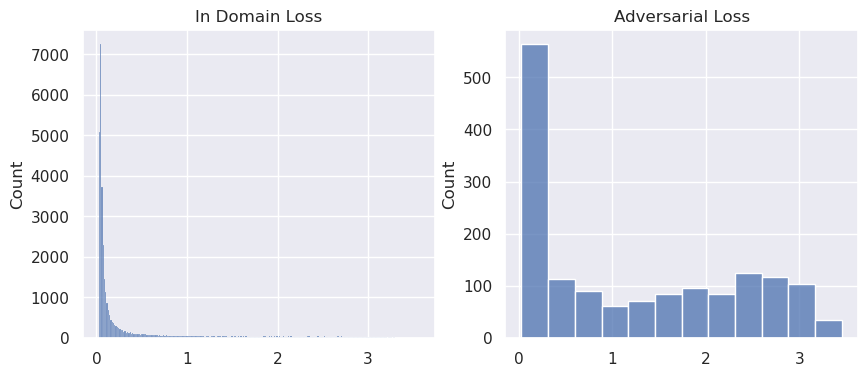

In [29]:
in_dist_loss = np.load('bert_ft_in_dist_loss.npy')
adv_loss = np.load('bert_ft_adv_loss.npy')


fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(in_dist_loss, ax=axs[0])
sns.histplot(adv_loss, ax=axs[1])
axs[0].set_title('In Domain Loss')
axs[1].set_title('Adversarial Loss')
plt.show()

## run previous data preprocessing cells ## 

In [30]:
# in_dist = in_dist.to_dict('records')
# adv = adv.to_dict('records')

# each elem looks like {'text': "wakens  \n  \n  \nThe harsh light of the midday sun cascaded over the young Mr. Quest's sleeping form. As the light slowly penetrated the skin of his eyelids a bit he stirred, obviously being roused (albeit slowly) from his peaceful slumber. But for once, even this short period of light did not bother him.",
#   'label': 0},

# tokenize
in_dist = [{'input_ids': elem['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(in_dist, in_dist_loss))]
adv = [{'input_ids': elem['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(adv, adv_loss))]

34268it [00:00, 182908.03it/s]
1540it [00:00, 2133871.21it/s]


### adversarial finetuning

In [33]:
from copy import deepcopy

rmodel = deepcopy(model)

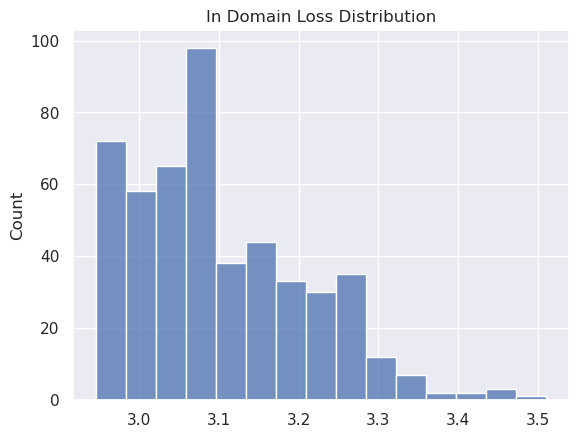

In [34]:
bootstrap_high_size = 500
high_frac = 1
final_train_size = 500

high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# sample high_frac of high loss examples
high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
to_train = torch.utils.data.ConcatDataset([high, rem])
to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # randomly sample target_train_size examples from in_dist_train
# to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

sns.histplot([elem[2].item() for elem in to_train])
plt.title('In Domain Loss Distribution')
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

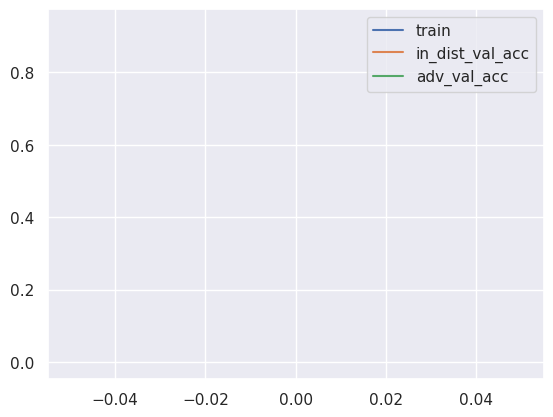

 31%|███▏      | 5/16 [00:09<00:19,  1.79s/it]

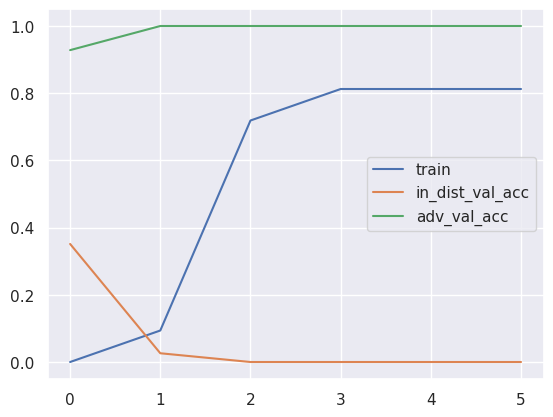

 62%|██████▎   | 10/16 [00:19<00:10,  1.83s/it]

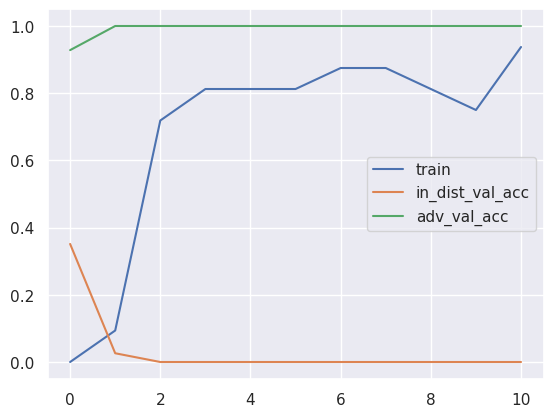

 94%|█████████▍| 15/16 [00:29<00:01,  1.87s/it]

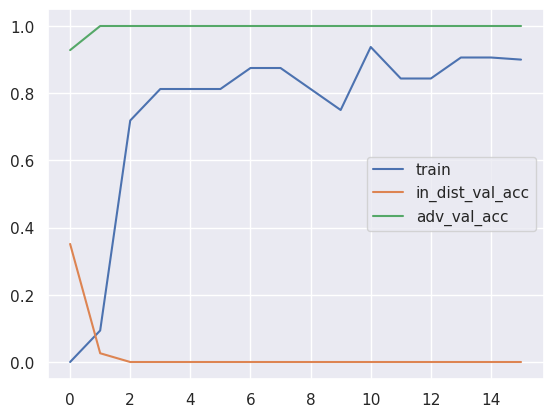

100%|██████████| 16/16 [00:32<00:00,  2.04s/it]


In [37]:
# just train for 1 epoch, evaluate on all datasets

train_batch_size = 32
eval_batch_size = 64
device = 0
model = model.to(device)

optimizer = torch.optim.Adam(rmodel.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

train_loss, eval_losses = train(rmodel, optimizer, criterion, to_train, train_batch_size, [in_dist_val_true, in_dist_val_false, adv_val_true, adv_val_false], eval_batch_size, device, num_epochs=1)

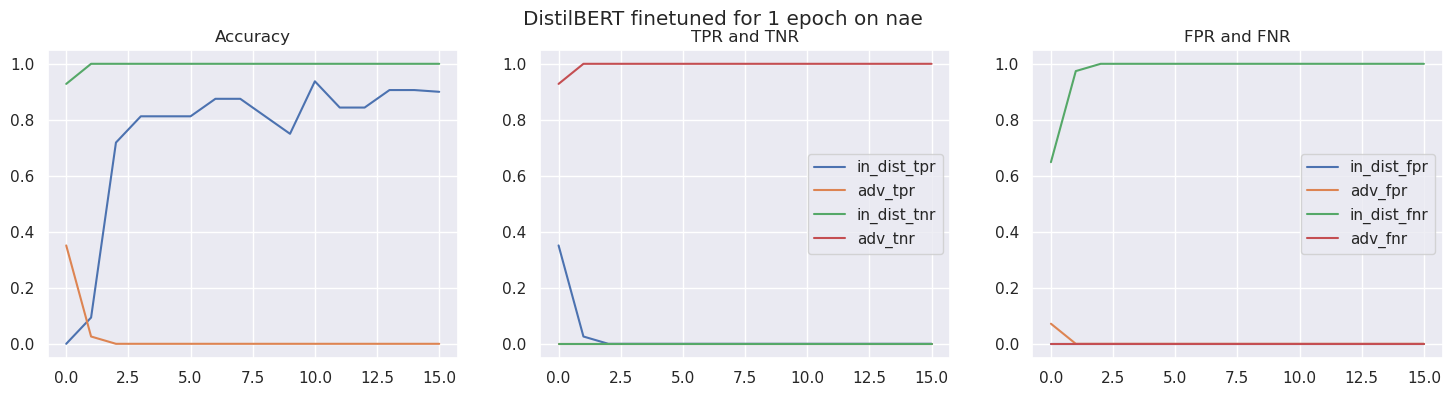

In [39]:
eval_losses = np.array(eval_losses)

in_dist_acc, in_dist_tpr, in_dist_fpr, in_dist_tnr, in_dist_fnr = eval_losses[:, 0, 0], eval_losses[:, 0, 1], eval_losses[:, 0, 2], eval_losses[:, 0, 3], eval_losses[:, 0, 4]
adv_acc, adv_tpr, adv_fpr, adv_tnr, adv_fnr = eval_losses[:, 1, 0], eval_losses[:, 1, 1], eval_losses[:, 1, 2], eval_losses[:, 1, 3], eval_losses[:, 1, 4]

# create 3 x 1 plots

import statsmodels.api as sm

fig, axs = plt.subplots(1,3, figsize=(18, 4))
sns.set()

lowess = sm.nonparametric.lowess(train_loss, range(len(train_loss)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])
lowess = sm.nonparametric.lowess(in_dist_acc, range(len(in_dist_acc)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])
lowess = sm.nonparametric.lowess(adv_acc, range(len(adv_acc)), frac=.2)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])

axs[0].set_title('Accuracy')

sns.lineplot(x=range(len(in_dist_tpr)), y=in_dist_tpr, label='in_dist_tpr', ax=axs[1])
sns.lineplot(x=range(len(adv_tpr)), y=adv_tpr, label='adv_tpr', ax=axs[1])
sns.lineplot(x=range(len(in_dist_fpr)), y=in_dist_tnr, label='in_dist_tnr', ax=axs[1])
sns.lineplot(x=range(len(adv_fpr)), y=adv_tnr, label='adv_tnr', ax=axs[1])
axs[1].set_title('TPR and TNR')

sns.lineplot(x=range(len(in_dist_tnr)), y=in_dist_fpr, label='in_dist_fpr', ax=axs[2])
sns.lineplot(x=range(len(adv_tnr)), y=adv_fpr, label='adv_fpr', ax=axs[2])
sns.lineplot(x=range(len(in_dist_fnr)), y=in_dist_fnr, label='in_dist_fnr', ax=axs[2])
sns.lineplot(x=range(len(adv_fnr)), y=adv_fnr, label='adv_fnr', ax=axs[2])
axs[2].set_title('FPR and FNR')

plt.suptitle('DistilBERT finetuned for 1 epoch on nae')
plt.show()

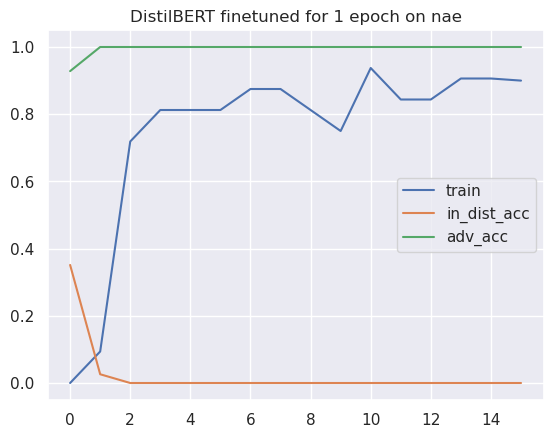

In [40]:
sns.lineplot(x=range(len(train_loss)), y=train_loss, label='train')
sns.lineplot(x=range(len(in_dist_acc)), y=in_dist_acc, label='in_dist_acc')
sns.lineplot(x=range(len(adv_acc)), y=adv_acc, label='adv_acc')
plt.title('DistilBERT finetuned for 1 epoch on nae')
plt.show()


In [44]:
# save in_dist_dataset and val_dataset

torch.save(in_dist_dataset, 'bert_in_dist_dataset.pt')
torch.save(adv_dataset, 'bert_adv_dataset.pt')

### deprecated